# DLL 52 Basics of NLP in Radiology - RSNA 2021

This session will feature a brief lecture introducing the basics of natural language processing (NLP) and highlight potential uses for it in radiology. This accompanying notebook will provide hands-on opportunity to explore some of the basic tools of NLP available in Python. 

**Learning Objectives:**
1.   Understand common terminology and preprocessing techniques in NLP
2.   Identify several classic and modern approaches used to capture semantic meaning in text
3. Learn how to implement a basic NLP pipeline from preprocessing to performance evaluation

**Session Authors**

Timothy L. Chen MD - University of California San Francisco, San Francisco, USA

Jae Ho Sohn MD, MS - University of California San Francisco, San Francisco, USA





# Install Packages

We will use a number of prepackaged python NLP tools for this demonstration. Google colab instances come preloaded with a number of packages but not everything. We will install the missing packages here.

Natural Language Toolkit ([NLTK](https://www.nltk.org/))

[spacy](https://spacy.io/) and [scispacy](https://allenai.github.io/scispacy/)

[gensim](https://radimrehurek.com/gensim/)

[sklearn](https://scikit-learn.org/stable/)






In [117]:
#@title Installing missing required packages
!pip install xmltodict >/dev/null
!pip install spacy > /dev/null 
!pip install scispacy > /dev/null
!pip install negspacy > /dev/null
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_md-0.4.0.tar.gz> /dev/null
!pip install contractions

#! pip freeze

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.5.0 requires spacy<3.6.0,>=3.5.0, but you have spacy 3.4.4 which is incompatible.
en-core-sci-md 0.4.0 requires spacy<3.1.0,>=3.0.1, but you have spacy 3.4.4 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scispacy 0.5.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.0.9 which is incompatible.
en-core-web-sm 3.5.0 requires spacy<3.6.0,>=3.5.0, but you have spacy 3.0.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Acquiring Data

This demo will utilize data from the [Indiana University CXR dataset](https://openi.nlm.nih.gov/faq). 

More information regarding the creation of this dataset is detailed in [1] *Demner-Fushman et. al. "Preparing a collection of radiology examinations for distirbution and retrieval". J. Am. Med. Inform. Assoc. 2016. doi: [10.1093/jamia/ocv080](https://academic.oup.com/jamia/article/23/2/304/2572395)*

In [118]:
# Download the data
# tar options - x -extract, v - show progress of archive file, z - filter archive through gzip
!curl https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz > NLMCXR_reports.tgz
!tar xvf /content/NLMCXR_reports.tgz >/dev/null


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1086k  100 1086k    0     0  2944k      0 --:--:-- --:--:-- --:--:-- 2944k


In [119]:
# taking a closer look at our file hierarchy
!dir

ecgen-radiology  NLMCXR_reports.tgz  sample_data


With permission from [2] Wiggins et. al., we borrow code to parse the xml. More information about this code can be found here: [Natural Language Processing of Radiology Text Reports: Interactive Text Classification](https://pubs.rsna.org/doi/full/10.1148/ryai.2021210035)

The XML file format stores data under various headers which we store as key-value pairs in a python dictionary object.

Here we first examine the data stucture of one such xml using an explicit file path. We want to extract the relevant text information from each file. We are interested in the text from the "FINDINGS" AND "IMPRESSION" keys. In addition, the reports are labeled as normal under the MeSH key - we will use this for labeling the reports as normal (if normal is present under MeSH) or abnormal.

If we closely examine the data, there are some oddities. Some entries are multiple xrays together. For example, 875.xml contains text for both CXR and a knee X-ray. Some CXR have no text under FINDINGS and IMPRESSION. For some chest x-ray, there is no label given ("No Indexing"). These "No Indexing" labels will be considered as normal for this exercise. 

In [120]:
import xmltodict

# function from Wiggins et. al.
def xml_parse(f):
  with open(f) as xml:
    report_dict = xmltodict.parse(xml.read())
    xml.close()
  return report_dict

Let's take a look at a random xml file and see the contents after parsing

In [121]:
reportdict_1 = xml_parse("./ecgen-radiology/1404.xml")
reportdict_1

{'eCitation': {'meta': {'@type': 'rr'},
  'uId': {'@id': 'CXR1404'},
  'pmcId': {'@id': '1404'},
  'docSource': 'CXR',
  'IUXRId': {'@id': '1404'},
  'licenseType': 'open-access',
  'licenseURL': 'http://creativecommons.org/licenses/by-nc-nd/4.0/',
  'ccLicense': 'byncnd',
  'articleURL': None,
  'articleDate': '2013-08-01',
  'articleType': 'XR',
  'publisher': 'Indiana University',
  'title': 'Indiana University Chest X-ray Collection',
  'note': 'The data are drawn from multiple hospital systems.',
  'specialty': 'pulmonary diseases',
  'subset': 'CXR',
  'MedlineCitation': {'@Owner': 'Indiana University',
   '@Status': 'supplied by publisher',
   'Article': {'@PubModel': 'Electronic',
    'Journal': {'JournalIssue': {'PubDate': {'Year': '2013',
       'Month': '08',
       'Day': '01'}}},
    'ArticleTitle': 'Indiana University Chest X-ray Collection',
    'Abstract': {'AbstractText': [{'@Label': 'COMPARISON', '#text': 'XXXX'},
      {'@Label': 'INDICATION',
       '#text': 'XXXX y


The entirety of the of the xml data files were uncompressed into the "ecgen-radiology" folder, so we will need to go through each file and extract the relevant information. The [glob](https://docs.python.org/3/library/glob.html) function in the glob module makes this easy by matching all files whose pathname matches a given pattern using [fnmatch](https://docs.python.org/3/library/fnmatch.html#module-fnmatch)

Additionally, we will extract relevant information from each xml file and store it into a pandas dataframe (which is basically a table).

In [122]:
# functions from Wiggins et. al. , slightly modified to remove dependence on fastai L class

def get_label(report):
    label = report['eCitation']['MeSH']['major']
    return 'normal' if label == 'normal' or label == "No Indexing" else 'abnormal'

def get_text(report):
    text_dict = {}
    text_dict['id'] = report['eCitation']['IUXRId']['@id']
    text = report['eCitation']['MedlineCitation']['Article']['Abstract']['AbstractText']
    findings = text[2]['#text'] if '#text' in text[2] else ''
    text_dict['findings'] = findings
    impression = text[3]['#text'] if '#text' in text[3] else ''
    text_dict['impression'] = impression
    text_dict['full-text'] = ' '.join([findings, impression])
    return text_dict

def process_report(report):
    label = get_label(report)
    report_dict = get_text(report)
    report_dict['label'] = label
    return report_dict


In [123]:
import glob
import pandas as pd

files = glob.glob("./ecgen-radiology/*")
reports = list()
reports_unlabeled = list()

for file in files:
  report_extract = xml_parse(file)
  if report_extract['eCitation']['MeSH']['major'] == "No Indexing":
    reports_unlabeled.append(file)
    
  reports.append(process_report(report_extract))
  
reports_df = pd.DataFrame(reports)


Let's examine some of the data in our table

The .head() function will return the first n rows (default 5) of the table. The .sample() method will randomly choose n rows of the table to display (default is 1)

In [124]:
print("# of reports:",reports_df.shape[0])
pd.options.display.max_colwidth = 0
reports_df.head()

# of reports: 3955


,id,findings,impression,full-text,label
0,3872,The cardiac contours are normal. The lungs are clear. Thoracic spondylosis.,No acute process.,The cardiac contours are normal. The lungs are clear. Thoracic spondylosis. No acute process.,abnormal
1,1833,There is a small area of scarring or atelectasis in the left base. Calcified granulomas seen in the posterior right lower lobe. Lungs are otherwise clear. The heart and mediastinum are normal. The skeletal structures and soft tissues are normal.,Minimal small area scarring of the left base.,There is a small area of scarring or atelectasis in the left base. Calcified granulomas seen in the posterior right lower lobe. Lungs are otherwise clear. The heart and mediastinum are normal. The skeletal structures and soft tissues are normal. Minimal small area scarring of the left base.,abnormal
2,3701,Both lungs are clear and expanded. Heart and mediastinum normal.,No active disease.,Both lungs are clear and expanded. Heart and mediastinum normal. No active disease.,normal
3,1789,,"Heart size is normal. Lungs are clear. Elevated right diaphragm, unchanged","Heart size is normal. Lungs are clear. Elevated right diaphragm, unchanged",abnormal
4,3503,The heart size is normal. The mediastinal contour is within normal limits. The lungs are free of any focal infiltrates. There are no nodules or masses. No visible pneumothorax. No visible pleural fluid. The XXXX are grossly normal. There is no visible free intraperitoneal air under the diaphragm.,No acute radiographic cardiopulmonary process.,The heart size is normal. The mediastinal contour is within normal limits. The lungs are free of any focal infiltrates. There are no nodules or masses. No visible pneumothorax. No visible pleural fluid. The XXXX are grossly normal. There is no visible free intraperitoneal air under the diaphragm. No acute radiographic cardiopulmonary process.,normal


In [125]:
reports_df.sample(5)

,id,findings,impression,full-text,label
32,1375,,"Cardiomegaly with interstitial edema. No effusions, pneumonia, nodules or masses.","Cardiomegaly with interstitial edema. No effusions, pneumonia, nodules or masses.",abnormal
3314,706,"Stable cardiomediastinal silhouette with normal heart size and aortic ectasia/tortuosity. No focal alveolar consolidation, no definite pleural effusion seen. Mild bronchovascular crowding without typical findings of pulmonary edema. Distal clavicle shortening also present on the previous exam, possibly posttraumatic or postsurgical.",No acute findings,"Stable cardiomediastinal silhouette with normal heart size and aortic ectasia/tortuosity. No focal alveolar consolidation, no definite pleural effusion seen. Mild bronchovascular crowding without typical findings of pulmonary edema. Distal clavicle shortening also present on the previous exam, possibly posttraumatic or postsurgical. No acute findings",abnormal
1366,2121,"The heart size is within normal limits. There is ectasia/tortuosity of the thoracic aorta. Calcified hilar lymph XXXX. Irregular calcific density projecting over the left lower lobe, stable since XXXX and may represent mitral annular calcifications. No focal airspace consolidation, pleural effusions or pneumothorax. Degenerative changes of the thoracic spine. No acute bony abnormalities.",No acute cardiopulmonary findings.,"The heart size is within normal limits. There is ectasia/tortuosity of the thoracic aorta. Calcified hilar lymph XXXX. Irregular calcific density projecting over the left lower lobe, stable since XXXX and may represent mitral annular calcifications. No focal airspace consolidation, pleural effusions or pneumothorax. Degenerative changes of the thoracic spine. No acute bony abnormalities. No acute cardiopulmonary findings.",abnormal
1723,1676,"Heart size and mediastinal contour within normal limits. Aortic atherosclerotic calcifications. Emphysematous changes. Nodular densities projecting over right anterior fifth and six ribs. No focal airspace consolidation, pneumothorax, or large pleural effusion. No acute osseous abnormality.",Nodular densities projecting over right 5th and 6th ribs may healing rib fracture; XXXX recommended to rule-out underlying pulmonary nodule. XXXX level Veriphy message was sent XXXX. XXXX regarding possible lung nodules at XXXX hours XXXX/XXXX.,"Heart size and mediastinal contour within normal limits. Aortic atherosclerotic calcifications. Emphysematous changes. Nodular densities projecting over right anterior fifth and six ribs. No focal airspace consolidation, pneumothorax, or large pleural effusion. No acute osseous abnormality. Nodular densities projecting over right 5th and 6th ribs may healing rib fracture; XXXX recommended to rule-out underlying pulmonary nodule. XXXX level Veriphy message was sent XXXX. XXXX regarding possible lung nodules at XXXX hours XXXX/XXXX.",abnormal
415,1663,"Cardiac size, mediastinal contour, and pulmonary vascularity are within normal limits. No focal consolidation, suspicious pulmonary opacity, pleural effusion, or pneumothorax. The visualized osseous structures appear intact.",No acute cardiopulmonary abnormalities.,"Cardiac size, mediastinal contour, and pulmonary vascularity are within normal limits. No focal consolidation, suspicious pulmonary opacity, pleural effusion, or pneumothorax. The visualized osseous structures appear intact. No acute cardiopulmonary abnormalities.",normal


# Some characteristics of the data

We previously already noticed that not all reports had labels associated with them and kept track of a list of such reports in reports_unlabeled. Through further examination of the data we see that some reports (e.g. id 68) only have an impression section but no findings section. THere are also numerous XXXX in reports which likely represent placeholder text after PHI removal (names, dates, etc). Even for normal labeled reports, there is quite a large amount of variation in the text of the reports.

## Distribution of labels

For any data, it is important to examine the distribution of classes (labels) of the data. Imbalanced datasets can have large impacts in terms of how a model behaves after training. 

Abnormal: 2469
Normal: 1486



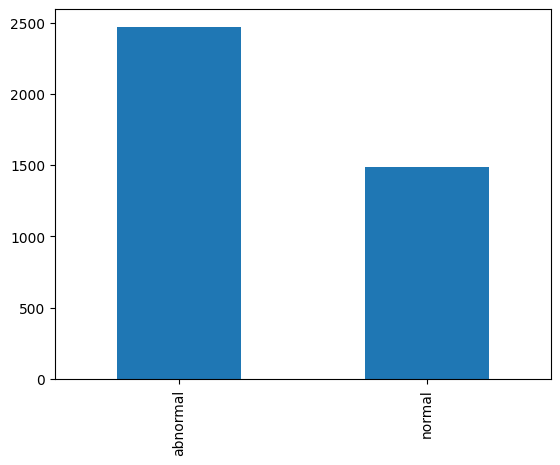

In [126]:
# code from Wiggins et. al.

label_counts = reports_df.label.value_counts()
print('Abnormal:', label_counts['abnormal'])
print('Normal:', label_counts['normal'])
print()
label_counts.plot.bar();

# Training and test set split

We will carve the data into two separate data sets - a training set to train the model and a test set to evaluate the model performance. It is necessary to use a separate dataset on which the model is not trained to evaluate the model because models can overfit onto training data and perform very well on that particular dataset but fail to generalize to examples it has not seen before.

Similarly, a third validation set is sometimes employed as part of the model development process for hyperparameter tuning which is  part of the training process.

For simplicity, we will use a single stratified train-test split, but a cross-validation approach with multiple train-test splits can offer better insight into how a model performs.

The stratification refers to how the sampling is done when the data is split into separate data sets. This is important when there is class imbalance in the dataset because you could conceivably end up with one dataset only having members of one class. 

The stratify option in the train_test_split function takes the labels of the dataset as input. When this option is enabled, the sampler will attempt to preserve class proportions of the input dataset (aka the input dataset labels) in the split datasets via stratified sampling. Note this does not solve the class imbalance problem on its own.

In [127]:
import numpy as np
from sklearn.model_selection import train_test_split

# fix seed for reproducibility
np.random.seed(2021)

train_df, test_df = train_test_split(reports_df, test_size=0.15, stratify=reports_df.label.values)

If we examine the dataset labels of the test set, we can see that we have similar proportions of abnormal and normal labels compared to the original full dataset (approx 62% abnormal)

Test set size: 594
Abnormal: 371
Normal: 223



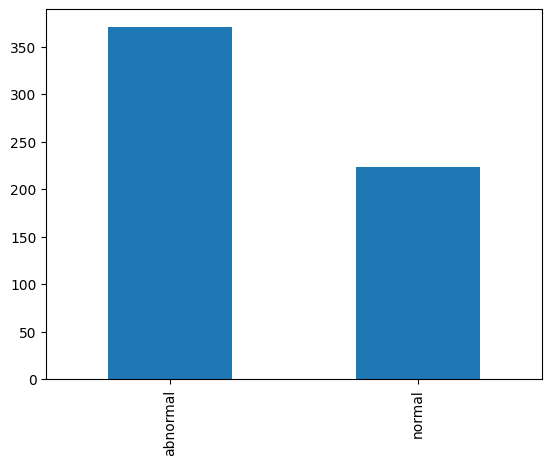

In [128]:
# code from Wiggins et. al.

print('Test set size:', test_df.shape[0])
test_counts = test_df.label.value_counts()
print('Abnormal:', test_counts['abnormal'])
print('Normal:', test_counts['normal'])
print()
test_counts.plot.bar();

# Preprocessing

Most models will not understand a stream of free text as is. Before we can use our data as input into a model, we need to convert it into a form that can be understood by an algorithm. Often this is done by creating a "vocabulary" of words such that every unique word has a unique index and thus we can input a word's index as input into a model (or use the index to look up some numerical representation of the word).

The following sections will examine pieces of a preprocessing pipeline in isolation using independent sections of code but then put these pieces together as one function at the end.

## Regular expressions (regex)
The data used in this tutorial was already nicely packaged into distinct Findings and Impression sections. Most of the time when working with radiology reports you'll have to divide the report into these separate entities yourself. One way to do this is with regular expressions which are rule based expressions that can match patterns of text. Regular expressions can be a powerful way to automatically segment reports or identify sections of text if pre-existing knowledge about their format is known.

[Cheat sheet](http://stanford.edu/~wpmarble/webscraping_tutorial/regex_cheatsheet.pdf) for regex syntax

We will not extensively cover regular expression nuances in this tutorial but just show a simple example of how they are used with respect to the Python re package. Regular expressions are a general framework thus you may also see packages outside of the re package which interface with regular expressions.

More about regular expressions can be found [here](https://www.regular-expressions.info/refflavors.html).


In [129]:
#@title
import re

regex_test_string = """
123-456-7890
(123)456-7890
(123)-456-7890
123 456 7890
123.456.7890
+1-123-456-7890
+1 (321) 456-7890
+91 123-456-7890
"""

regex_pattern = "\+?(\d{1,3})?[-. (]?[-. (]?(\d{3})[-. )]?[-. )]?\d{3}[-. ]?\d{4}"#@param {type:"string"}
m = re.finditer(regex_pattern,regex_test_string)

for match in m:
  print(match.group())
  print(f"Area code is {match.group(2)}\n")

123-456-7890
Area code is 123

(123)456-7890
Area code is 123

(123)-456-7890
Area code is 123

123 456 7890
Area code is 123

123.456.7890
Area code is 123

+1-123-456-7890
Area code is 123

+1 (321) 456-7890
Area code is 321

+91 123-456-7890
Area code is 123



Note by default regex does greedy matching
Greedy matching - match as much as text as possible to fulfill the pattern even if a smaller subsection of the text would have already fulfilled the pattern.

In the following example we look for a string that begins with "h", has at least one character of anything except line breaks, and then an "l".

If our test string is "hello" , then the substring "hel" matches our objective but so does "hell" if we go one character further. The default behavior is to return the longer version (hence greedy). If we wanted the non-greedy version, adding a "?" after a quantifier makes it non-greedy.

In [130]:
#@title
regex_pattern = "h.+l"
m = re.finditer(regex_pattern,"hello")
for match in m:
  print(match.group())

hell


In [131]:
#@title
regex_pattern = "h.+?l"
m = re.finditer(regex_pattern,"hello")
for match in m:
  print(match.group())

hel


## Word Tokenization

The first step in processing text is often tokenization. This is a process in which text is split into discrete sections which are known as tokens. A natural place to create these sections (for English) is dividing at spaces so that each word represents a token. However, tokens could also be defined at a phrase level (multiple words), sentence level, or character level. For simplicity here, we will tokenize at the single word level.

In [132]:
import nltk
nltk.download('punkt')
text = "Heart size upper limits of normal. Mediastinal contours are maintained. The patient is mildly rotated. There is a small to moderate sized right apical pneumothorax which measures approximately 2.0 cm. No focal airspace consolidation is seen. Left chest is clear. No definite displaced bony injury is seen. Results called XXXX. XXXX XXXX p.m. XXXX, XXXX. Small to moderate right apical pneumothorax."
text_tokens = nltk.tokenize.word_tokenize(text)
print(text_tokens)

['Heart', 'size', 'upper', 'limits', 'of', 'normal', '.', 'Mediastinal', 'contours', 'are', 'maintained', '.', 'The', 'patient', 'is', 'mildly', 'rotated', '.', 'There', 'is', 'a', 'small', 'to', 'moderate', 'sized', 'right', 'apical', 'pneumothorax', 'which', 'measures', 'approximately', '2.0', 'cm', '.', 'No', 'focal', 'airspace', 'consolidation', 'is', 'seen', '.', 'Left', 'chest', 'is', 'clear', '.', 'No', 'definite', 'displaced', 'bony', 'injury', 'is', 'seen', '.', 'Results', 'called', 'XXXX', '.', 'XXXX', 'XXXX', 'p.m.', 'XXXX', ',', 'XXXX', '.', 'Small', 'to', 'moderate', 'right', 'apical', 'pneumothorax', '.']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Stopword removal

Stop words are high-frequeny words in language that tend to appear in any context due to their grammatical role (e.g. "a", "the", "of"). They generally do not contain much information, so it is customary to remove these words as part of the prprocessing step. In general this works well, but phrases that rely on stopwords can lose meaning (e.g. "to be or not to be"). 

In this case, XXXX should be removed as well.

Removal of stopwords is as simple as defining a set of words that you want to remove and then removing these words by scanning through input text and filtering out words that are within the set.


In [133]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The imported stopwords exist originally as a list structure, but we should convert to a set for better performance. We can also add custom words to expand this set. Notice our set of stopwords is also all lower case. We will lowercase our tokens prior to matching to the stopword set.

In addition to stopwords, numbers are often removed as well (e.g. list numberings) but in the context of radiology these numbers can be very important (e.g. size of a lung nodule).

In [134]:
import string
stop = set(stopwords.words('english')+list(string.punctuation))
stop.add("xxxx")

filtered_tokens = [i.lower() for i in text_tokens if i.lower() not in stop ]
print(filtered_tokens)

['heart', 'size', 'upper', 'limits', 'normal', 'mediastinal', 'contours', 'maintained', 'patient', 'mildly', 'rotated', 'small', 'moderate', 'sized', 'right', 'apical', 'pneumothorax', 'measures', 'approximately', '2.0', 'cm', 'focal', 'airspace', 'consolidation', 'seen', 'left', 'chest', 'clear', 'definite', 'displaced', 'bony', 'injury', 'seen', 'results', 'called', 'p.m.', 'small', 'moderate', 'right', 'apical', 'pneumothorax']


## Word normalization - stemming and lemmatization

Word (or text) normalization is reducing text to a standardized form before processing. One way to do this is word stemming and/or lemmatization. In word stemming, the suffix of a word is removed, often leaving behind a stem that is not a full word. In lemmatization, words are transformed into a base word. For example, it is common to remove verb conjugations to reduce different forms of a verb to a single word/token - transforming flying, flown, flew -> fly. 

We will introduce the concept here, but it will not be included within the preprocessing pipeline. Medical stemming is a difficult topic due to many words sharing roots while still having different meanings (e.g. pneumonia, pneumonitis, pneumonic, pneumothorax). Most available stemming packages are not designed for medical stemming and could introduce problems by truncating useful parts of words ("over stemming"). 

In addition to stemming/lemmatizing words which are based on word roots, one can normalize words by mapping words to a controlled vocabulary. This is especially useful in medicine where a number of terms could refer to the same entity (e.g. hepatorenal recess vs subhepatic recess vs pouch of Morison vs Morison's pouch). Examples of efforts to create standardized medical vocabulary include [UMLS](https://www.nlm.nih.gov/research/umls/index.html), [SNOMED-CT](https://www.nlm.nih.gov/healthit/snomedct/index.html), and [RadLex](http://radlex.org/)

In [135]:
import nltk
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The [Porter Stemmer](http://snowball.tartarus.org/algorithms/porter/stemmer.html) is a commonly used stemmer which uses an extensive rule based approach to stem words. The stems generated by stemming may not be "real" words which is ok as the point is to normalize similar words into the same token.

In [136]:
stemmer = PorterStemmer()
stemmer.stem("flying")

'fli'

In [137]:
print(stemmer.stem("pneumonic"))
print(stemmer.stem("pneumonitis"))

pneumon
pneumon


For lemmatization demonstration, we will use the NLTK default lemmatizer which is based on [WordNet](https://wordnet.princeton.edu/). In addition to the target text, the [lemmatizer](https://www.nltk.org/_modules/nltk/stem/wordnet.html) will generally require a part of speech parameter to be fully functional (default is noun)

In [138]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize("flown",pos="v"))

fly


## Negation

Dealing with negation is important especially when using a bag of word model because it ignores word ordering. The presence of a word in a document does not mean we necessarily want it to always be used as the same feature especially if the word is qualified by "no" (e.g. no nodule). One way to deal with this is to detect such negated words/phrases and create "new" vocab words out of negated entities by appending some text to it (for example append "NEGEX_" to negated entities so that these entities are counted as separated words compared to their non-negated counterpart)

spacy comes with pre-trained [models](https://github.com/explosion/spacy-models) for purposes of preprocessing (e.g. named entity recognition) and also [negation](https://github.com/jenojp/negspacy). Here we will use a default implementation of negspacy for negation detection.

In [139]:
import scispacy
import spacy
from negspacy.negation import Negex
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string

nlp = spacy.load("en_core_sci_md")
nlp.add_pipe("negex")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


What kind of phrases is negex recognizing as negation? We can print the default patterns from negspaCy to see. The "en_clinical" dataset is used by default. Default termsets also include "en" and "en_clinical_sensitive". The official documentation covers how to change term sets and also how to add/remove custom phrases to the sets.

From the documentation, negspaCy uses four patterns:

**pseudo_negations** - phrases that are false triggers, ambiguous negations, or double negatives

**preceding_negations** - negation phrases that precede an entity

**following_negations** - negation phrases that follow an entity

**termination** - phrases that cut a sentence in parts, for purposes of negation detection (.e.g., "but")

In [140]:
from negspacy.termsets import termset

ts = termset("en_clinical")
ts_dict = ts.get_patterns()

for key,value in ts_dict.items():
  print(key,value)
  print("\n")

pseudo_negations ['no further', 'not able to be', 'not certain if', 'not certain whether', 'not necessarily', 'without any further', 'without difficulty', 'without further', 'might not', 'not only', 'no increase', 'no significant change', 'no change', 'no definite change', 'not extend', 'not cause', 'gram negative', 'not rule out', 'not ruled out', 'not been ruled out', 'not drain', 'no suspicious change', 'no interval change', 'no significant interval change']


preceding_negations ['absence of', 'declined', 'denied', 'denies', 'denying', 'no sign of', 'no signs of', 'not', 'not demonstrate', 'symptoms atypical', 'doubt', 'negative for', 'no', 'versus', 'without', "doesn't", 'doesnt', "don't", 'dont', "didn't", 'didnt', "wasn't", 'wasnt', "weren't", 'werent', "isn't", 'isnt', "aren't", 'arent', 'cannot', "can't", 'cant', "couldn't", 'couldnt', 'never', 'patient was not', 'without indication of', 'without sign of', 'without signs of', 'without any reactions or signs of', 'no complaints

## Expanding Contractions

Contractions are words that are shorted by combining two originally seperated words together with an apostophe. Examples of contractions in the English language are don't and can't. This step in preprocessing can help because it allows us to expand words and get more meaning from the text, as well as help with the negation step shown above.

In [141]:
# import the contractions library
import contractions

#method one of handling contractions
def expandContractions(tokenList):
  expanded_words = []
  for word in tokenList:
    expanded_words.extend(contractions.fix(word).split()) 
  return expanded_words

#method 2 of handling contractions
def quickContractions(text):
  return contractions.fix(text)

In [142]:
#test for contractions
testContraction = "I'd love to meet your friend! I'll be it's me"
print(expandContractions(testContraction.split()))
print(quickContractions(testContraction))

['I', 'would', 'love', 'to', 'meet', 'your', 'friend!', 'I', 'will', 'be', 'it', 'is', 'me']
I would love to meet your friend! I will be it is me


## Putting it all together

In [143]:
from nltk.corpus import stopwords

def preprocess(nlp_model,input_text):
  input_text = input_text.strip()
  doc = nlp_model(input_text)
  negation_list = [0]*len(doc)
  tokens = list()
  stop = set(stopwords.words('english')+list(string.punctuation))
  stop.add("xxxx")
  #The code above will not remove XXXX from the code which is present many times. We have to manually add a lowercase xxxx
  #remove this stopwords as the code written does not account for stopwords in the stop array being uppercase. 
  stop.add("xxxx")

  lenNormal = len(re.findall(r'normal.{0,4}', input_text))
  lenActive = len(re.findall(r'active.{0,4}', input_text))
  lenSize = len(re.findall(r'size.{0,4}', input_text))
  lenDisease = len(re.findall(r'disease.{0,4}', input_text))
  lenClear = len(re.findall(r'clear.{0,4}', input_text))
  lenHeart = len(re.findall(r'heart.{0,4}', input_text))
  lenLung = len(re.findall(r'lung.{0,4}', input_text))
  lenCardiomediastinal = len(re.findall(r'cardiomediastinal.{0,4}', input_text))
  lenWithin = len(re.findall(r'within.{0,4}', input_text))
  lenContours = len(re.findall(r'contour.{0,4}', input_text))

  tokens.append(str(lenNormal) + "numNormal")
  tokens.append(str(lenActive) + "numActive")
  tokens.append(str(lenSize) + "numSize")
  tokens.append(str(lenDisease) + "numDisease")
  tokens.append(str(lenClear) + "numClear")
  tokens.append(str(lenHeart) + "numHeart")
  tokens.append(str(lenLung) + "numLung")
  tokens.append(str(lenCardiomediastinal) + "numCardiomediastinal")
  tokens.append(str(lenWithin) + "numWithin")
  tokens.append(str(lenContours) + "numContour")


  for ent in doc.ents:
    if ent._.negex:
      index = ent.start
      while index < ent.end:
        negation_list[index] = 1
        index += 1
        
  for i,token in enumerate(doc):
    #we need to lower stopwords because of this
    if str(token).lower() not in stop:
      if negation_list[i] == 1:
        tokens.append(("NEGEX_"+str(token).lower()))
      else:
        tokens.append(str(token).lower())
  
  #We will contract our tokens in this step. In this step we are using method 1 to expand contractions. 
  tokens = expandContractions(tokens)

  return tokens


## Creating a vocabulary
After preprocessing the text, it is time to scan through the entire training corpus (aka all of the text available) and create a vocabulary which is essentially an index of all tokens encountered.

We will use the gensim [Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html) class for this as it has some useful methods.

We can also set a threshold to filter out tokens using the gensim dict method filter_extremes() that occur below a specified frequency. This could be useful for removing misspelled words.

In [144]:
from gensim.corpora import Dictionary

train_text = train_df["full-text"].to_list()

def token_generator(text_list):
  for text in text_list:
    yield preprocess(nlp,text)

train_tokens = token_generator(train_text)
train_vocab_dict = Dictionary(train_tokens)

# gensim Dictionary does not create an id2token dictionary  until dictionary is called
train_vocab_dict[0]

'0numActive'

In [145]:
len(train_vocab_dict.token2id)

2362

## Visualizing the preprocessing steps

In [146]:
reports_df['tokens'] = reports_df['full-text'].apply(lambda text:preprocess(nlp, text))
reports_df

,id,findings,impression,full-text,label,tokens
0,3872,The cardiac contours are normal. The lungs are clear. Thoracic spondylosis.,No acute process.,The cardiac contours are normal. The lungs are clear. Thoracic spondylosis. No acute process.,abnormal,"[1numNormal, 0numActive, 0numSize, 0numDisease, 1numClear, 0numHeart, 1numLung, 0numCardiomediastinal, 0numWithin, 1numContour, cardiac, contours, normal, lungs, clear, thoracic, spondylosis, NEGEX_acute, NEGEX_process]"
1,1833,There is a small area of scarring or atelectasis in the left base. Calcified granulomas seen in the posterior right lower lobe. Lungs are otherwise clear. The heart and mediastinum are normal. The skeletal structures and soft tissues are normal.,Minimal small area scarring of the left base.,There is a small area of scarring or atelectasis in the left base. Calcified granulomas seen in the posterior right lower lobe. Lungs are otherwise clear. The heart and mediastinum are normal. The skeletal structures and soft tissues are normal. Minimal small area scarring of the left base.,abnormal,"[2numNormal, 0numActive, 0numSize, 0numDisease, 1numClear, 1numHeart, 0numLung, 0numCardiomediastinal, 0numWithin, 0numContour, small, area, scarring, atelectasis, left, base, calcified, granulomas, seen, posterior, right, lower, lobe, lungs, otherwise, clear, heart, mediastinum, normal, skeletal, structures, soft, tissues, normal, minimal, small, area, scarring, left, base]"
2,3701,Both lungs are clear and expanded. Heart and mediastinum normal.,No active disease.,Both lungs are clear and expanded. Heart and mediastinum normal. No active disease.,normal,"[1numNormal, 1numActive, 0numSize, 1numDisease, 1numClear, 0numHeart, 1numLung, 0numCardiomediastinal, 0numWithin, 0numContour, lungs, clear, expanded, heart, mediastinum, normal, active, disease]"
3,1789,,"Heart size is normal. Lungs are clear. Elevated right diaphragm, unchanged","Heart size is normal. Lungs are clear. Elevated right diaphragm, unchanged",abnormal,"[1numNormal, 0numActive, 1numSize, 0numDisease, 1numClear, 0numHeart, 0numLung, 0numCardiomediastinal, 0numWithin, 0numContour, heart, size, normal, lungs, clear, elevated, right, diaphragm, unchanged]"
4,3503,The heart size is normal. The mediastinal contour is within normal limits. The lungs are free of any focal infiltrates. There are no nodules or masses. No visible pneumothorax. No visible pleural fluid. The XXXX are grossly normal. There is no visible free intraperitoneal air under the diaphragm.,No acute radiographic cardiopulmonary process.,The heart size is normal. The mediastinal contour is within normal limits. The lungs are free of any focal infiltrates. There are no nodules or masses. No visible pneumothorax. No visible pleural fluid. The XXXX are grossly normal. There is no visible free intraperitoneal air under the diaphragm. No acute radiographic cardiopulmonary process.,normal,"[3numNormal, 0numActive, 1numSize, 0numDisease, 0numClear, 1numHeart, 1numLung, 0numCardiomediastinal, 1numWithin, 1numContour, heart, size, normal, mediastinal, contour, within, normal, limits, NEGEX_lungs, free, NEGEX_focal, NEGEX_infiltrates, NEGEX_nodules, NEGEX_masses, visible, pneumothorax, visible, pleural, fluid, grossly, normal, visible, free, NEGEX_intraperitoneal, air, NEGEX_diaphragm, NEGEX_acute, radiographic, cardiopulmonary, process]"
...,...,...,...,...,...,...
3950,508,Normal heart size and mediastinal contours. No focal airspace consolidation. No pleural effusion or pneumothorax. Visualized osseous structures are unremarkable.,No acute cardiopulmonary abnormality.,Normal heart size and mediastinal contours. No focal airspace consolidation. No pleural effusion or pneumothorax. Visualized osseous structures are unremarkable. No acute cardiopulmonary abnormality.,normal,"[1numNormal, 0numActive, 1numSize, 0numDisease, 0numClear, 1numHeart, 0numLung, 0numCardiomediastinal, 0numWithin, 1numContour, normal, heart, size, mediastinal, contours, NEGEX_focal, NE

We will also need to process the test set for later use. Note we don't create a dictionary from the test tokens as it is may contain "out of vocabulary words" that would not have been seen in training. We need to simulate how our model pipeline behaves when it encounters unseen text/words.

In [147]:
test_text = test_df["full-text"].to_list()
test_tokens = token_generator(test_text)

# Classification model - introducing Naive Bayes

## Theory

Naive Bayes (NB) derives its name from Bayes' theorem.

Our objective is to classifiy a document d with the best possible class prediction, $\hat{c}$, where $c$ is the true class of document $d$

$ \hat{c} = \underset{c \in C}{argmax} \: P(c|d) = \underset{c \in C}{argmax} \frac{P(d|c)P(c)}{P(d)} $

$P(d)$ is a constant so we can just find the class c that maximizes the numerator of the expression

$ \hat{c} = \underset{c \in C}{argmax} \: P(d|c)P(c) $

$P(c)$ is readily determined - it is the frequency of class c in the training set.

For $P(d|c)$, we let the words (tokens) of document d be the features that define it. We assume the order of these features does not matter (bag of words) and that the probability of a feature occurring in document d is independent of other words already inside of document d (conditional independence between every pair of tokens).

Based on this $P(d|c) = P(x_{1}, x_{2},...,x_{n}| c)$ where $x_i$ are the tokens x in d. If we assume independence among these words then this probability further breaks down into:

$\prod_{i = 1}^{n}{P(x_{i}|c)}$

The different variations of Naive Bayes come from the different assumptions of what we assume the probability distribution of $P(x_{i}|c)$ looks like. 

If we assume a multinomial distribution, then we can estimate the probability $P(x_{i}|c)$ as $\theta_{c,i}$ where the maximum likelihood estimator for theta for a multinomial is:

$\theta_{c,i} = \frac{N_{c,i}}{N_{c}}$

where $N_{c,i}$ is the total count of the token i occurring in class c and $N_{c}$ is the number of total tokens in class c. In practice, we use an additional smoothing term to this estimator by giving an extra count of $\alpha$ to all words. This is to account for cases in which a token does not appear in class c to avoid a 0 in our product.

$\theta_{c,i} = \frac{N_{c,i}+\alpha}{N_{c}+\alpha n}$ where n is the number of unique tokens

See [here](https://scikit-learn.org/stable/modules/naive_bayes.html) for more information

## Code

In [148]:
y_train = list(map(int,(train_df['label'] != "normal").to_list()))
y_test = list(map(int,(test_df['label'] != "normal").to_list()))

The sklearn naive bayes implementation does not take compressed representations of a sparse matrix as input, so we will have to create a sparse vector representation of our bag of words format

In [149]:
def sparse_vector_create(tuple_list,vocab_len):
#tuple_list will have data structure akin to gensim dictionary doc2bow output 
  sparse_vector = np.zeros(vocab_len)
  for id,freq in tuple_list:
    sparse_vector[id] = freq
  return sparse_vector

def sparse_vector_generator(tokens,vocab_dict,vocab_len):
  for token in tokens:
    yield sparse_vector_create(vocab_dict.doc2bow(token),vocab_len)

# recreate generator object to reset it , otherwise will output empty result
train_tokens = token_generator(train_text)
x_train_sparse = [sparse_vector for sparse_vector in sparse_vector_generator(train_tokens,train_vocab_dict,len(train_vocab_dict))]


In [150]:
from sklearn import naive_bayes

nb_classifier = naive_bayes.MultinomialNB(alpha=1.0)

nb_classifier.fit(x_train_sparse,y_train)

MultinomialNB()

Let's try running our model on the test set. The test set may have words that are not included in the training vocabulary, so we will need 1 additional preprocessing step to handle such out-of-vocabulary words. The simplest approach is to simply ignore such words. The gensim dictionary doc2bow function automatically ignores out of vocabulary words.

Other tokenization techniques (especially sub-word or character level) may avoid this issue all together by ensuring any string of text encontered is able to be tokenized and thus included into the vocabulary.

In [151]:
# doc2bow ignores out of vocabulary words
train_vocab_dict.doc2bow(["madeupword"])

[]

In [152]:
# basically the same code as the training version above but we're not storing each iteration of the for loop into an array

test_tokens = token_generator(test_text)
nb_predictions = list()

for token in test_tokens:
  test_sparse_vector = sparse_vector_create(train_vocab_dict.doc2bow(token),len(train_vocab_dict))
  nb_predictions.append(nb_classifier.predict(test_sparse_vector.reshape(1,-1))[0])
 

# More on sparse word vectors - term frequency inverse document frequency (tf-idf)

## Theory

### tfidf

Earlier we created vectors of raw term counts with respect to each document. These were called sparse vectors because they were largely 0 as many unique words tend to not show up in may documents and thus the counts of those words was 0 for most documents - represented as a 0 in the term vector in the corresponding index for that word.

There is a related concept called term frequency-inverse document frequency. We start with related quantity to term count: the term frequency. For a given document d and term t, the term frequency(tf) is is $\frac{f_{t,d}}{\sum_{t' \in d}{f_{t',d}}}$ where the denominator is just the number of words/terms in the document. Sometimes we prefer using the log of the tf term as importance of a term does not increase linearly but rather "peaks" after a certain point.

We then multiply this "tf" by another term - the inverse document frequency (idf) which is usually $log{\frac{N}{n_t}}$ where N is number of total documents and $n_t$ is number of documents that contain the term t.

For an unseen document, the tf is readily calculated. The idf for the terms in the document however uses the weighting learned from the training data.

More on sklearn [tfidf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)

### Support Vector Machine (SVM)



The theory behind SVM is outside of the scope of this tutorial. However intuitively SVM classifiers classify data by finding a "hyper-plane" that separates two classes of data. One can think of a hyper plane as the multidimensional generalization of a line which the equivalent of a hyperplane for 2D space, or a plane which is the hyperplane for 3D space. The hyperplane is basically a linear "plane" in N dimensional space that separates the space into two sections (hence the plane being N-1 dimensional). The optimization objective for SVM is set such that it will choose a hyperplane by finding the plane that has the maximum "margin" between the two classes i.e. the largest distance between the plane and the closest data point of each class.

## Code

The sklearn library readily comes with implementation of [tfidf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) and [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) which we will use here.

In [153]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(use_idf=True, smooth_idf = True,sublinear_tf = True)
tfidf.fit(x_train_sparse)
x_train_tfidf= tfidf.transform(x_train_sparse)

In [154]:
from sklearn import svm

SVM = svm.SVC(C=1.0,kernel ='linear')
SVM.fit(x_train_tfidf,y_train)

SVC(kernel='linear')

In [155]:
test_tokens = token_generator(test_text)
svm_predictions = list()

for token in test_tokens:
  test_sparse_vector = sparse_vector_create(train_vocab_dict.doc2bow(token),len(train_vocab_dict))
  x_test_tfidf = tfidf.transform(test_sparse_vector.reshape(1,-1))
  svm_predictions.append(SVM.predict(x_test_tfidf)[0])
  

# Where to next?
So far we have only examined sparse word vectors. That is, vector representations of words that contain many 0's and sparsely contain data. This may perform adequately for the models presented, but for many cases, working with large-dimension vectors can be a large problem due to high memory usage and computational cost.

There has been work done to create dense vectors of words based on "distributed" representations (aka based on word distribution). These vectors are are usually only several tens to hundreds of dimensions long as opposed to many thousands. Earlier approaches for doing so include Word2vec and GloVe which create static vectors for word representations. Newer embedding approaches integrate context into embedding creation such as seen in ELMo or BERT's embedding process. 

Popular deep learning architectures for analyzing text include convolutional neural networks, recurrent neural networks and its cousins LSTM and GRU as well as the more recent transformer model. Deep learning approaches to NLP start with converting words into a vector in an embedding layer, often using one of the aforementioned techniques. We will not explore deep learning approaches to NLP in this tutorial, but since we have mentioned a number of popular NLP packages, we will also mention [HuggingFace](https://huggingface.co/) for their extensive NLP deep learning library. 

# Evaluation

Evaluation of model performance is a very important part of the NLP pipeline. Common metrics (for classification) include sensitivity (recall), specificity, positive predictive value (precision), and the F1 score. These quantities can be derived from a "confusion matrix" which is simply a matrix that tabulates model classification results into the categories of true negatives, false positives, false negatives, and true positives.

For sklearn confusion matrix, the format is - row i is actual class, row j is predicted class. For our case, 0 - normal, 1 - abnormal. thus $C_{0,0}$ is true negatives, $C_{0,1}$ is false positive, $C_{1,0}$ is false negative, $C_{1,1}$ is true positives where $C_{i,j}$ refers to element in row i and column j. In this example, a "positive" label by the model is the equivalent of flagging an example as "abnormal".

Note we cannot naturally generate a ROC curve for Naive Bayes or SVM as ROC curves require some threshold (usually some "probability" cut off for prediction of one class or another) but Naive Bayes simply compares two(or more) quantities with each other to determine class. While using relative comparisons works reasonably well, the numerical value of these outputs is unstable and unsuitable for a fixed cutoff.

In [156]:
from sklearn import metrics

class metric_calc:
  def __init__(self, y,y_hat):
  # y is true label, y_hat is predicted label
    self.y_hat = y_hat
    self.y = y
    conf_matrix = metrics.confusion_matrix(y,y_hat)
    
    self.true_neg = conf_matrix[0][0]
    self.false_pos = conf_matrix[0][1]
    self.false_neg = conf_matrix[1][0]
    self.true_pos = conf_matrix[1][1]

  def conf_matrix_values(self):
    print(f"TN: {self.true_neg}, FP: {self.false_pos}, FN: {self.false_neg} TP: {self.true_pos}")

  def sens_spec(self):
    sens = self.true_pos/(self.true_pos+self.false_neg)
    spec = self.true_neg/(self.true_neg+self.false_pos)
    print(f"Sensitivity (aka recall) is {sens:.4f}")
    print(f"Specificity is {spec:.4f}")

  def incorrect_index(self):
    # return indices of examples that are incorrectly predicted
    index = list()
    for i,label in enumerate(self.y):
      if label != self.y_hat[i]:
        index.append(i)
    return index


print("Naive Bayes")
nb_metric = metric_calc(y_test,nb_predictions)
nb_metric.conf_matrix_values()
nb_metric.sens_spec()

print("SVM")
svm_metric = metric_calc(y_test,svm_predictions)
svm_metric.conf_matrix_values()
svm_metric.sens_spec()

Naive Bayes
TN: 219, FP: 4, FN: 46 TP: 325
Sensitivity (aka recall) is 0.8760
Specificity is 0.9821
SVM
TN: 217, FP: 6, FN: 4 TP: 367
Sensitivity (aka recall) is 0.9892
Specificity is 0.9731


In [157]:
len(nb_predictions)

594

# Manual examination of model

Sometimes it is helpful (or simply entertaining) to try inserting your own free text into a NLP model and seeing how it behaves

In [158]:
#@title Try entering some free text for classification via the classifiers we trained
user_text = "no disease" #@param {type:"string"}
user_token = preprocess(nlp,user_text)
user_sparse_vector = sparse_vector_create(train_vocab_dict.doc2bow(user_token),len(train_vocab_dict))
user_nb_prediction = nb_classifier.predict(user_sparse_vector.reshape(1,-1))[0]
user_svm_prediction = SVM.predict(user_sparse_vector.reshape(1,-1))[0]

print("Convention used - 0 is normal, 1 is abnormal")
print(f"Naive Bayes: {user_nb_prediction}")
print(f"SVM: {user_svm_prediction}")

Convention used - 0 is normal, 1 is abnormal
Naive Bayes: 0
SVM: 0


## Error Analysis

Manual examination of model errors for systematic errors is also an important post evaluation step.

In [159]:
troubleshoot_df = test_df.iloc[svm_metric.incorrect_index()][["full-text","label"]]
troubleshoot_df["SVM"] = [svm_predictions[i] for i in svm_metric.incorrect_index()]
troubleshoot_df

,full-text,label,SVM
1198,"The aortic XXXX, cardiac apex, and stomach are left-sided. Cardiomediastinal silhouette is within normal limits in overall size and appearance. Pulmonary vascular markings are symmetric and within normal limits. The lungs are normally inflated with no focal airspace disease, pleural effusion, or pneumothorax. No acute bony abnormality. 1. No acute cardiopulmonary process.",normal,1
2175,Heart size is within normal limits. Aorta is tortuous. Remainder of the cardiomediastinal silhouette is normal. Lungs are clear bilaterally without pleural effusion or pneumothorax. No bony abnormalities. No active disease.,abnormal,0
3269,"Heart XXXX, mediastinum, XXXX, bony structures and lung XXXX are unremarkable. No significant interval change compared to prior study, no XXXX infiltrates noted. No radiographic evidence of acute cardiopulmonary disease",normal,1
3704,XXXX XXXX and lateral chest examination was obtained. The heart silhouette and mediastinal contours are not enlarged. Removal of 2 left-sided chest tubes. There is no pneumothorax. Lungs demonstrate no acute findings. There is minimal posterior pleural effusions. 1. No pneumothorax following removal of left-sided chest tubes.,abnormal,0
2645,The heart is normal in size. The mediastinum is unremarkable. The lungs are clear. No acute disease.,abnormal,0
1004,The heart size and pulmonary vascularity appear within normal limits. Lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. No discrete nodules or adenopathy are noted. Degenerative changes are present in the spine. No evidence of active disease.,normal,1
1559,XXXX XXXX and lateral views of the chest were obtained on 02/010/XXXX. The lung volumes are normal. The lungs are clear and there are no pleural effusions. There is stable mild tenting of the medial aspect of the right diaphragm. The mediastinum and pulmonary XXXX are normal. The bony elements are not remarkable. No acute cardiopulmonary abnormalities are seen. END OF REPORT.,normal,1
3747,The cardiomediastinal silhouette is within normal limits. The lungs are clear without areas of focal consolidation. No pneumothorax or pleural effusion. XXXX lucency under the right hemidiaphragm may represent a focus of free air. 1. XXXX lucency under the right hemidiaphragm may represent free intraperitoneal air. Left lateral decubitus film may be helpful. 2. Clear lungs.,normal,1
1485,Heart size upper limits normal. Sternotomy. Right-sided aortic XXXX. Lungs are clear.,normal,1
1936,The lungs are clear. The heart and pulmonary XXXX appear normal. Pleural spaces are clear. The mediastinal contours are normal. Bony overlap in the lung apices could obscure a small pulmonary nodule. No acute cardiopulmonary disease,abnormal,0


In [160]:
troubleshoot_df = test_df.iloc[nb_metric.incorrect_index()][["full-text","label"]]
troubleshoot_df["nb"] = [nb_predictions[i] for i in nb_metric.incorrect_index()]
troubleshoot_df

,full-text,label,nb
239,The cardiomediastinal contours are within normal limits. Pulmonary vasculature is unremarkable. There is no focal airspace opacity. No pleural effusion or pneumothorax is seen. Multiple healed bilateral rib fractures. No acute bony abnormality is identified. No acute cardiopulmonary abnormality.,abnormal,0
1943,1. Chest. No visible active cardiopulmonary disease. 2. Left hip. Advanced posttraumatic osteoarthritis.,normal,1
1228,"PA and lateral radiograph the chest demonstrate stable cardiomediastinal silhouette. No focal consolidation, large pleural effusion, or pneumothorax is identified. Evidence of prior granulomatous disease. Visualized osseous structures appear intact. No acute cardiopulmonary abnormality.",abnormal,0
95,"Heart size, mediastinal contour, and pulmonary vascularity are within normal limits. Stable tortuosity of the thoracic aorta. No focal consolidation, pleural effusion, or pneumothorax is identified. No acute osseous abnormality identified. No acute cardiopulmonary abnormality. .",abnormal,0
3851,Lungs appear hyperinflated. This may be secondary to XXXX voluntary XXXX considering patient's age. Clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.,abnormal,0
719,The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. Small T-spine osteophytes. No acute cardiopulmonary abnormality.,abnormal,0
1018,"The trachea is midline. The cardiomediastinal silhouette is normal and unchanged compared to prior examination. The lungs are clear, without evidence of acute infiltrate or effusion. There is no pneumothorax. The visualized bony structures reveal no acute abnormalities. There is hiatal hernia. No acute cardiopulmonary abnormalities.",abnormal,0
144,"The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Left basilar subsegmental atelectasis versus scar noted. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality. No acute cardiopulmonary abnormality. Specifically, no evidence of active tuberculous process.",abnormal,0
2175,Heart size is within normal limits. Aorta is tortuous. Remainder of the cardiomediastinal silhouette is normal. Lungs are clear bilaterally without pleural effusion or pneumothorax. No bony abnormalities. No active disease.,abnormal,0
3305,"The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There are mild degenerative changes of the spine. No acute cardiopulmonary disease.",abnormal,0


# Changes to the code

## Change 1: Expanding contractions as a preprocessing step and bug fix

For this change, I added an extra preprocessing step that helped expand contractions. Please go to In hindsight, after I had wrote the code to put the tokens and the orignial full text side by side, I realized that many medical texts and descriptions don't even use contracts normally, but nevertheless this will help catch contractions and lengthen them if and when they arise. 

A bug I did end up catching in the proprocessing step was in the stopwords list. We had added the stopword "XXXX", but that doesn't actually do anything since the preprocess function puts everything to lowercase when comparing stopwords. Instead, we need to add the lowercase "xxxx" to our stopwords set to get the desired result.

If we go to Visualizing the processing steps as well, we can see the original full-text and the proprocessed tokenized text side by side.

## Change 2: Which words get misclassified often?

## Change 3: Added Regex to match how much times a commonly word appears


This step is done in the Putting it All Together Tab. We find that by adding commonly used words and putting a number on it, we increase specificity, which means people are more correctly getting classified as normal rather than abnormal. Sensitivity stays around the same. 

# References

[1] Demner-Fuhshman D, Kohli MD, Rosenman MB, Shooshan SE, Rodriguez L, Antani S, Thoma GR, McDonald CJ. "Preparing a collection of radiology examinations for distribution and retrieval". J. Am. Med. Inform. Assoc. 2016. 23(2). 304-310. https://doi.org/10.1093/jamia/ocv080

[2] Wiggins WF, Kitamura F, Santos I, Prevedello L. "Natural Language Processing of Radiology Text Reports: Interactive Text Classification". Radiol. Artif. Intell. 2021. 3(4). https://doi.org/10.1148/ryai.2021210035

#Further Reading
Jurafsky D, Martin JH. "Speech and Language Processing. An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition". Draft. 3ed. September 21, 2021.

Pons E, Braun LM M, Hunink MG Myriam, Kors JA. "Natural Language Processing in Radiology: A Systematic Review". Radiology. 2016. 279(2). 329-343.

Sorin V, Barash Y, Konen E, Klang E. "Deep Learning for Natural Language Processing in Radiology - Fundamentals and a Systematic Review". J. Am. Coll. Radiol. 2020. 17(5). 639-648.

Mozayan A, Fabbri AR, Maneevese M, Tocino I, Chheang Sophie. "Practical Guide to Natural Language Processing for Radiology". Radiographics. 2021. 41(5). 1446-1453.

# Most misclassified words

In [161]:
troubleshoot_df = test_df.iloc[nb_metric.incorrect_index()][["full-text","label"]]
troubleshoot_df["nb"] = [nb_predictions[i] for i in nb_metric.incorrect_index()]

troubleshoot_df['tokens'] = troubleshoot_df['full-text'].apply(lambda text:preprocess(nlp, text))
troubleshoot_df

mem = dict()
for tokenList in troubleshoot_df['tokens']:
  for token in tokenList:
    mem[token] = mem.get(token, 0) + 1



In [162]:
memKeys = list(mem.keys())
memValues = list(mem.values())

In [163]:
d = {"words": memKeys, "count": memValues}
misclassified = pd.DataFrame(data=d)

In [164]:
misclassified

,words,count
0,3numNormal,6
1,0numActive,46
2,0numSize,30
3,0numDisease,34
4,0numClear,19
...,...,...
259,could,1
260,obscure,1
261,nodule,1
262,hilar,1


In [165]:
totalCount = list(misclassified["count"])

In [166]:
misclassified = misclassified.sort_values(by=["count"], ascending = False)
misclassified

,words,count
13,normal,55
30,NEGEX_acute,51
1,0numActive,46
40,0numContour,37
81,lungs,37
...,...,...
151,closure,1
148,airspace,1
147,focal,1
146,radiographic,1


In [167]:
misclassified10 = misclassified.head(10)
misclassified10

,words,count
13,normal,55
30,NEGEX_acute,51
1,0numActive,46
40,0numContour,37
81,lungs,37
90,clear,37
5,0numHeart,36
34,NEGEX_cardiopulmonary,35
3,0numDisease,34
38,0numCardiomediastinal,33


<Axes: ylabel='words'>

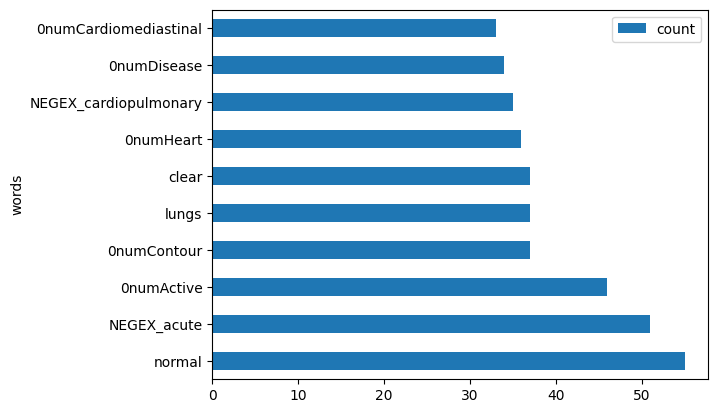

In [168]:
misclassified10.plot.barh(x="words", y="count")

In [169]:
troubleshoot_df = test_df.iloc[nb_metric.incorrect_index()][["full-text","label"]]
troubleshoot_df["nb"] = [nb_predictions[i] for i in nb_metric.incorrect_index()]

troubleshoot_df['tokens'] = troubleshoot_df['full-text'].apply(lambda text:preprocess(nlp, text))
troubleshoot_df


,full-text,label,nb,tokens
239,The cardiomediastinal contours are within normal limits. Pulmonary vasculature is unremarkable. There is no focal airspace opacity. No pleural effusion or pneumothorax is seen. Multiple healed bilateral rib fractures. No acute bony abnormality is identified. No acute cardiopulmonary abnormality.,abnormal,0,"[3numNormal, 0numActive, 0numSize, 0numDisease, 0numClear, 0numHeart, 0numLung, 1numCardiomediastinal, 1numWithin, 1numContour, cardiomediastinal, contours, within, normal, limits, pulmonary, vasculature, unremarkable, NEGEX_focal, NEGEX_airspace, NEGEX_opacity, NEGEX_pleural, NEGEX_effusion, NEGEX_pneumothorax, seen, multiple, healed, bilateral, rib, fractures, NEGEX_acute, NEGEX_bony, NEGEX_abnormality, NEGEX_identified, NEGEX_acute, NEGEX_cardiopulmonary, NEGEX_abnormality]"
1943,1. Chest. No visible active cardiopulmonary disease. 2. Left hip. Advanced posttraumatic osteoarthritis.,normal,1,"[0numNormal, 1numActive, 0numSize, 1numDisease, 0numClear, 0numHeart, 0numLung, 0numCardiomediastinal, 0numWithin, 0numContour, 1, chest, visible, active, cardiopulmonary, disease, 2, left, hip, advanced, posttraumatic, osteoarthritis]"
1228,"PA and lateral radiograph the chest demonstrate stable cardiomediastinal silhouette. No focal consolidation, large pleural effusion, or pneumothorax is identified. Evidence of prior granulomatous disease. Visualized osseous structures appear intact. No acute cardiopulmonary abnormality.",abnormal,0,"[1numNormal, 0numActive, 0numSize, 1numDisease, 0numClear, 0numHeart, 0numLung, 1numCardiomediastinal, 0numWithin, 0numContour, pa, lateral, radiograph, chest, demonstrate, stable, cardiomediastinal, silhouette, NEGEX_focal, NEGEX_consolidation, large, NEGEX_pleural, NEGEX_effusion, NEGEX_pneumothorax, NEGEX_identified, evidence, prior, granulomatous, disease, visualized, osseous, structures, appear, intact, NEGEX_acute, NEGEX_cardiopulmonary, NEGEX_abnormality]"
95,"Heart size, mediastinal contour, and pulmonary vascularity are within normal limits. Stable tortuosity of the thoracic aorta. No focal consolidation, pleural effusion, or pneumothorax is identified. No acute osseous abnormality identified. No acute cardiopulmonary abnormality. .",abnormal,0,"[3numNormal, 0numActive, 1numSize, 0numDisease, 0numClear, 0numHeart, 0numLung, 0numCardiomediastinal, 1numWithin, 1numContour, heart, size, mediastinal, contour, pulmonary, vascularity, within, normal, limits, stable, tortuosity, thoracic, aorta, NEGEX_focal, NEGEX_consolidation, NEGEX_pleural, NEGEX_effusion, NEGEX_pneumothorax, NEGEX_identified, NEGEX_acute, osseous, NEGEX_abnormality, NEGEX_identified, NEGEX_acute, NEGEX_cardiopulmonary, NEGEX_abnormality]"
3851,Lungs appear hyperinflated. This may be secondary to XXXX voluntary XXXX considering patient's age. Clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.,abnormal,0,"[2numNormal, 0numActive, 0numSize, 0numDisease, 0numClear, 0numHeart, 1numLung, 0numCardiomediastinal, 1numWithin, 1numContour, lungs, appear, hyperinflated, may, secondary, voluntary, considering, patient, 's, age, clear, lungs, mediastinal, contour, within, normal, limits, NEGEX_acute, NEGEX_cardiopulmonary, NEGEX_abnormality, NEGEX_identified]"
719,The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. Small T-spine osteophytes. No acute cardiopulmonary abnormality.,abnormal,0,"[2numNormal, 0numActive, 0numSize, 0numDisease, 0numClear, 0numHeart, 0numLung, 1numCardiomediastinal, 1numWithin, 0numContour, cardiomediastinal, silhouette, pulmonary, vasculature, within, normal, limits, NEGEX_pneumothorax, NEGEX_pleural, NEGEX_effusion, NEGEX_focal, NEGEX_areas, NEGEX_consolidation, small, t-spine, osteophytes, NEGEX_acute, NEGEX_cardiopulmonary, NEGEX_abnormality]"
1018,"The trachea is midline. The cardiomediastinal silhouette is 

In [170]:
mem1 = dict()
mem0 = dict()
for tokenList in troubleshoot_df['tokens']:
  for token in tokenList:
    mem1[token] = 0
    mem0[token] = 0

In [171]:
for i in range(len(troubleshoot_df)):
  if troubleshoot_df.iloc[i]["nb"] == 1:
    for token in troubleshoot_df.iloc[i]["tokens"]:
      mem1[token] += 1
  else:
    for token in troubleshoot_df.iloc[i]["tokens"]:
      mem0[token] += 1

In [172]:
index = list(mem0.keys())

In [173]:
vis = pd.DataFrame({'Misclassifying 0': list(mem0.values()),
                   'Misclassifying 1': list(mem1.values()),
                    "total": totalCount}, index=index)

In [174]:
vis

,Misclassifying 0,Misclassifying 1,total
3numNormal,5,1,6
0numActive,43,3,46
0numSize,26,4,30
0numDisease,32,2,34
0numClear,17,2,19
...,...,...,...
could,1,0,1
obscure,1,0,1
nodule,1,0,1
hilar,1,0,1


In [175]:
vis10 = vis.sort_values(by="total", ascending= False).head(10).sort_values(by="total").drop("total", axis = 1)
vis10

,Misclassifying 0,Misclassifying 1
0numCardiomediastinal,30,3
0numDisease,32,2
NEGEX_cardiopulmonary,33,2
0numHeart,32,4
0numContour,33,4
lungs,34,3
clear,34,3
0numActive,43,3
NEGEX_acute,49,2
normal,52,3


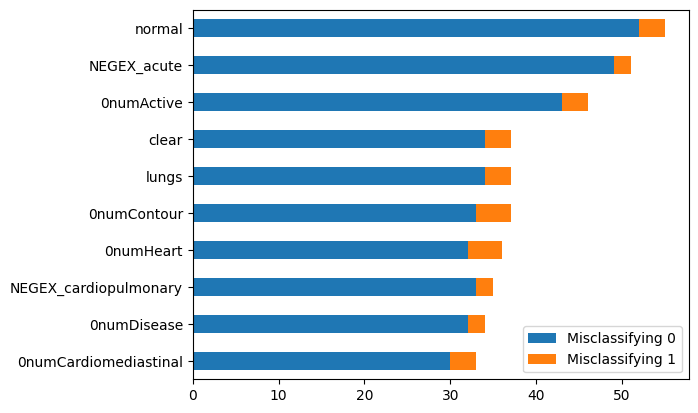

In [176]:
ax = vis10.plot.barh(stacked=True)